In [1]:
import numpy as np
from datetime import datetime

import torch
import torchvision

from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim
from torch import nn
from torchvision.utils import save_image

In [2]:
batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# class Encoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(x_size, h_size)
#         self.mu_gen = nn.Linear(h_size, z_size)
#         # make the output to be the logarithm 
#         # i.e will have to take the exponent
#         # which forces variance to be positive
#         # not that this is the diagonal of the covariance
#         self.log_var_gen = nn.Linear(h_size, z_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         mu = self.mu_gen(x)
#         log_var = self.log_var_gen(x)
#         return mu, log_var
    
class Encoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim=10):

        super(Encoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        cnn_kwargs = dict(stride=2, padding=1)

        self.conv1 = nn.Conv2d(n_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        if self.img_size[1] == self.img_size[2] == 64:
            self.conv_64 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.lin1 = nn.Linear(np.product(self.reshape), hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)

        self.mu_logvar_gen = nn.Linear(hidden_dim, self.latent_dim * 2)

    def forward(self, x):
        batch_size = x.size(0)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.conv_64(x))

        x = x.view((batch_size, -1))
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))

        mu_logvar = self.mu_logvar_gen(x)

        mu, logvar = mu_logvar.view(-1, self.latent_dim, 2).unbind(-1)

        return mu, logvar

In [5]:
# class Decoder(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(z_size, h_size)
#         self.fc3 = nn.Linear(h_size, x_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc3(x))
#         # black and white MNIST => sigmoid for each pixel
#         x = torch.sigmoid(x) 
#         return x
    
class Decoder(nn.Module):
    r"""
    References:
            [1] Burgess, Christopher P., et al. "Understanding disentangling in
            $\beta$-VAE." arXiv preprint arXiv:1804.03599 (2018).
    """
    def __init__(self, img_size, latent_dim):

        super(Decoder, self).__init__()

        hidden_channels = 32
        kernel_size = 4
        hidden_dim = 256

        self.img_size = img_size
        self.latent_dim = latent_dim

        self.reshape = (hidden_channels, kernel_size, kernel_size)

        n_channels = self.img_size[0]

        self.lin1 = nn.Linear(latent_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, np.product(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)

        if self.img_size[1] == self.img_size[2] == 64:
            self.convT_64 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)

        self.convT1 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(hidden_channels, n_channels, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)

        x = torch.relu(self.lin1(z))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))

        x = x.view(batch_size, *self.reshape)

        if self.img_size[1] == self.img_size[2] == 64:
            x = torch.relu(self.convT_64(x))

        x = torch.relu(self.convT1(x))
        x = torch.relu(self.convT2(x))

        x = torch.sigmoid(self.convT3(x))

        return x

In [6]:
# class VAE(nn.Module):
#     def __init__(self, x_size, h_size, z_size):
#         super(VAE, self).__init__()
#         self.x_size = x_size
#         self.z_size = z_size
#         self.encoder = Encoder(x_size, h_size, z_size)
#         self.decoder = Decoder(x_size, h_size, z_size)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var) # square root in exponent => std
#         eps = torch.randn_like(std)
#         z = std * eps + mu
#         return z

#     def forward(self, x):
#         # make image linear (i.e vector form)
#         x = x.view(-1, self.x_size)
#         mu, log_var = self.encoder(x)
#         z = self.reparameterize(mu, log_var)
#         x_hat = self.decoder(z)
#         return x_hat, mu, log_var

class VAE(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(VAE, self).__init__()
        if list(img_size[1:]) not in [[32,32], [64,64]]:
            raise RuntimeError("{} sized images not supported. Only (None, 32, 32) and (None, 64, 64) supported. Build your own architecture or reshape images!".format(img_size))

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.num_pixels = self.img_size[1] * self.img_size[2]
        self.encoder = Encoder(img_size, self.latent_dim)
        self.decoder = Decoder(img_size, self.latent_dim)

        self.reset_parameters()

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + std * eps

        else:
            return mean


    def forward(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        reconstruct = self.decoder(latent_sample)
        return reconstruct, latent_distribution, latent_sample

    def reset_parameters(self):
        self.apply(weights_init)

    def sample_latent(self, x):
        latent_distribution = self.encoder(x)
        latent_sample = self.reparameterize(*latent_distribution)
        return latent_sample

In [7]:
def get_activation_name(activation):
    """Given a string or a `torch.nn.modules.activation` return the name of the activation."""
    if isinstance(activation, str):
        return activation

    mapper = {nn.LeakyReLU: "leaky_relu", nn.ReLU: "relu", nn.Tanh: "tanh",
              nn.Sigmoid: "sigmoid", nn.Softmax: "sigmoid"}
    for k, v in mapper.items():
        if isinstance(activation, k):
            return k

    raise ValueError("Unkown given activation type : {}".format(activation))


def get_gain(activation):
    """Given an object of `torch.nn.modules.activation` or an activation name
    return the correct gain."""
    if activation is None:
        return 1

    activation_name = get_activation_name(activation)

    param = None if activation_name != "leaky_relu" else activation.negative_slope
    gain = nn.init.calculate_gain(activation_name, param)

    return gain
def linear_init(layer, activation="relu"):
    """Initialize a linear layer.
    Args:
        layer (nn.Linear): parameters to initialize.
        activation (`torch.nn.modules.activation` or str, optional) activation that
            will be used on the `layer`.
    """
    x = layer.weight

    if activation is None:
        return nn.init.xavier_uniform_(x)

    activation_name = get_activation_name(activation)

    if activation_name == "leaky_relu":
        a = 0 if isinstance(activation, str) else activation.negative_slope
        return nn.init.kaiming_uniform_(x, a=a, nonlinearity='leaky_relu')
    elif activation_name == "relu":
        return nn.init.kaiming_uniform_(x, nonlinearity='relu')
    elif activation_name in ["sigmoid", "tanh"]:
        return nn.init.xavier_uniform_(x, gain=get_gain(activation))
def weights_init(module):
    if isinstance(module, nn.modules.conv._ConvNd):
        # TO-DO: check litterature
        linear_init(module)
    elif isinstance(module, nn.Linear):
        linear_init(module)

In [8]:
def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed

def _kl_normal_loss(mean, logvar):
    latent_dim = mean.size(1)
    latent_kl = 0.5 * (-1 - logvar + mean.pow(2) + logvar.exp()).mean(dim=0)
    total_kl = latent_kl.sum()

    return total_kl

def _reconstruction_loss(data, recon_data, distribution="bernoulli"):
    batch_size, n_channels, height, width = recon_data.size()
    is_colored = n_channels == 3

    if distribution == "bernoulli":
        loss = F.binary_cross_entropy(recon_data, data, reduction="sum")

    elif distribution == "gaussian":
        loss = F.mse_loss(recon_data * 255, data * 255, reduction="sum") / 255

    elif distribution == "laplace":
        loss = F.l1_loss(recon_data, data, reduction="sum")
        loss = loss * 3
        loss = loss * (loss != 0)

    loss = loss / batch_size

    return loss

def loss_function(x_hat, x, mu, log_var, is_train, n_train_steps, steps_anneal=0, beta=1, C_init=0., C_fin=20., gamma=100.):
    """Compute the ELBO loss"""
    x_size = x_hat.size(-1)
    # black or white image => use sigmoid for each pixel
#     rec_loss = F.binary_cross_entropy(x_hat, x.view(-1, x_size), reduction='sum')
    rec_loss = _reconstruction_loss(x, x_hat, distribution="bernoulli")
    # closed form solution for gaussian prior and posterior
#     kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_div = _kl_normal_loss(mu, log_var)
    
    C = (linear_annealing(C_init, C_fin, n_train_steps, steps_anneal) if is_train else C_fin)
    vae_loss = rec_loss + gamma * (kl_div - C).abs()
#     vae_loss = rec_loss + beta * kl_div
    return vae_loss

In [9]:
class Trainer:
    def __init__(self, model, optimizer=optim.Adam, loss_function=loss_function):
        self.model = model 
        self.optimizer = optimizer(self.model.parameters())
        self.loss_function = loss_function
        self.epoch = 0
        
    def __call__(self, train, test, n_epochs=100):
        self.epoch = 0
        for _ in range(n_epochs):
            self._train_epoch(train)
            self._test_epoch(test)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           '../results/sample_' + str(self.epoch) + '.png')
        
    def _train_epoch(self, train):
        self.epoch += 1
        model.train() # make sure train mode (e.g. dropout)
        train_loss = 0
        for i, (x, _) in enumerate(train):
            x = x.to(device) # data on GPU 
            self.optimizer.zero_grad() # reset all previous gradients
            x_hat, latent_distribution, latent_sample = model(x)
            loss = self.loss_function(x_hat, x, *latent_distribution, True, i)
            loss.backward() # backpropagate (i.e store gradients)
            train_loss += loss.item() # compute loss (.item because only the value)
            self.optimizer.step() # take optimizing step (~gradient descent)

        print('Epoch: {} Train loss: {:.4f}'.format(
              self.epoch, train_loss / len(train.dataset)))
        
    def _test_epoch(self, test):
        model.eval() # make sure evaluate mode (e.g. dropout)
        test_loss = 0
        with torch.no_grad():  # stop gradients computation
            for i, (x, _) in enumerate(test):
                x = x.to(device)
                x_hat, latent_distribution, latent_sample = model(x)
                test_loss += loss_function(x_hat, x, *latent_distribution, False, i).item()

        print('Test loss: {:.4f}'.format(test_loss/len(test.dataset)))


In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

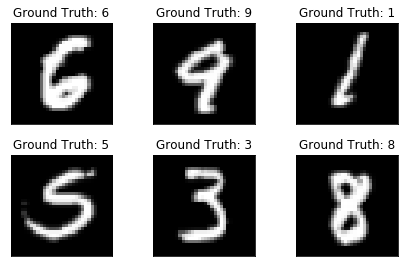

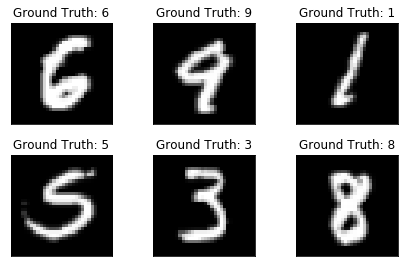

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [12]:
list(example_data[0].shape)

[1, 32, 32]

In [13]:
img_size = list(example_data[0].shape) # mnist image
# h_size = 256
z_size = 12
model = VAE(img_size, z_size).to(device) # migrates to CUDA if you can

In [14]:
model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lin1): Linear(in_features=512, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (mu_logvar_gen): Linear(in_features=256, out_features=24, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [15]:
# trainer = Trainer(model)

In [16]:
# %%time
# trainer(train_loader, test_loader)

In [17]:
# torch.save(model.state_dict(), './model/betaVAE.pt')

In [18]:
# older model
# model.load_state_dict(torch.load('./model/betaVAE.pt'))

In [19]:
class SiameseDiscriminator(nn.Module):
    def __init__(self, image_size):
        super(SiameseDiscriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),

            nn.Conv2d(4, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.Conv2d(8, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8 * 26 * 26, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 15)
        )
    
    def forward_once(self, x):
        """Define the computation performed at every call by one side of siamese network."""
#         x = x_.unsqueeze(0)
#         print(x.shape)
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        """Define the computation performed at every call."""
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [20]:
class SiameseLoss(nn.Module):
    def __init__(self, margin):
        super(Loss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)
    
    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [21]:
class DistanceBasedLoss(nn.Module):
    """
    Distance based loss function.
    For reference see:
    Hadsell et al., CVPR'06
    Chopra et al., CVPR'05
    Vo and Hays, ECCV'16
    """

    def __init__(self, margin):
        """Set parameters of distance-based loss function."""
        super(DistanceBasedLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [22]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin):
        """Set parameters of contrastive loss function."""
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        clamped = torch.clamp(self.margin - euclidean_distance, min=0.0)
        similar_loss = (1 - label) * 0.5 * torch.pow(euclidean_distance, 2)
        dissimilar_loss = label * 0.5 * torch.pow(clamped, 2)
        contrastive_loss = similar_loss + dissimilar_loss

        return torch.mean(contrastive_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [23]:
from math import exp


def gaussian(window_size, sigma):
    """Compute gaussian window, that is a tensor with values of the bell curve."""
    gauss = torch.Tensor(
        [exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel):
    """Generate a two dimensional window with desired number of channels."""
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    """Compute the structural similarity index between two images."""
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1) *
                                                    (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class SSIM(nn.Module):
    """Wrapper class used to compute the structural similarity index."""

    def __init__(self, window_size=11, size_average=True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        """Execute the computation of the structural similarity index."""
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

In [24]:
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler


class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.targets
            self.train_data = self.mnist_dataset.data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.targets
            self.test_data = self.mnist_dataset.data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return torch.FloatTensor([target]), img1, img2

    def __len__(self):
        return len(self.mnist_dataset)

In [25]:
mnist_siamese_dataset = SiameseMNIST(mnist_dataset)
mnist_siamese_dataset_test = SiameseMNIST(mnist_dataset_test)

In [26]:
class Config:
    def __init__(self, image_size=32, mode='train', model_path='./model/Siamese', 
                 generate_path='./Generated', num_epochs=100, distance_weight=1.0, 
                 dataset='MNIST', tensorboard=True, generator=model, batch_size=64, batch_size_test=1000):
        self.mode = mode
        self.image_size = image_size
        self.model_path = model_path
        self.generate_path = generate_path
        self.dataset = dataset
        self.num_epochs = num_epochs
        self.distance_weight = distance_weight
        self.tensorboard = tensorboard
        self.generator = generator
        self.batch_size = batch_size
        self.batch_size_test = batch_size_test

In [27]:
from tqdm import tqdm
class SiameseGanSolver(object):
    """Solving GAN-like neural network with siamese discriminator."""

    def __init__(self, config, data_loader):
        """Set parameters of neural network and its training."""
        self.ssim_loss = SSIM()
        self.generator = config.generator
        self.discriminator = None
        self.distance_based_loss = None

        self.g_optimizer = None
        self.d_optimizer = None

        self.g_conv_dim = 128

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.learning_rate = 0.0001
        self.image_size = config.image_size
        self.num_epochs = config.num_epochs
        self.distance_weight = config.distance_weight

        self.data_loader = data_loader
#         print(self.data_loader.dataset)
        self.generate_path = config.generate_path
        self.model_path = config.model_path
        self.tensorboard = config.tensorboard

        if self.tensorboard:
            self.tb_writer = tensorboardX.SummaryWriter(
                filename_suffix='_%s_%s' % (config.distance_weight, config.dataset))
            self.tb_graph_added = False

        self.build_model()

    def build_model(self):
        """Build generator and discriminator."""
#         self.generator = Generator(self.g_conv_dim, noise=self.noise, residual=self.residual)
        self.discriminator = SiameseDiscriminator(self.image_size)
        self.distance_based_loss = DistanceBasedLoss(2.0)

        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(), self.learning_rate, [self.beta1, self.beta2])
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), self.learning_rate, [self.beta1, self.beta2])

        if torch.cuda.is_available():
            self.generator.cuda()
            self.discriminator.cuda()
            self.distance_based_loss.cuda()

    def train(self):
        """Train generator and discriminator in minimax game."""
        # Prepare tensorboard writer
        if self.tensorboard:
            step = 0
        
        print("We are training\n")

        for epoch in tqdm(range(self.num_epochs)):
            print(str(epoch) + " " + str(datetime.now()))
#             i = 0
            for label, images0, images1 in self.data_loader:
#                 i += 1
#                 print(i)
                images0 = to_variable(images0)
                images1 = to_variable(images1)
#                 print("label:", label)
                label = to_variable(label)
#                 print("We extracted samples")
                # Train discriminator to recognize identity of real images
                output0, output1 = self.discriminator(images0, images1)
                d_real_loss = self.distance_based_loss(output0, output1, label)
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                d_real_loss.backward()
                self.d_optimizer.step()
#                 print("We did backprop")
                # Train discriminator to recognize identity of fake(privatized) images
                
                privatized_imgs, _, _ = self.generator(images0)
#                 print(privatized_imgs)
                output0, output1 = self.discriminator(images0, privatized_imgs)

                # Discriminator wants to minimize Euclidean distance between
                # original & privatized versions, hence label = 0
                d_fake_loss = self.distance_based_loss(output0, output1, 0)
                distance = 1.0 - self.ssim_loss(privatized_imgs, images0)
                d_fake_loss += self.distance_weight * distance
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                d_fake_loss.backward()
                self.d_optimizer.step()

                # Train generator to fool discriminator
                # Generator wants to push the distance between original & privatized
                # right to the margin, hence label = 1
                privatized_imgs, _, _ = self.generator(images0)
                output0, output1 = self.discriminator(images0, privatized_imgs)
                g_loss = self.distance_based_loss(output0, output1, 1)
                distance = 1.0 - self.ssim_loss(privatized_imgs, images0)
                g_loss += self.distance_weight * distance
#                 print("We calculated loss")
                # Backpropagation
                self.distance_based_loss.zero_grad()
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()

                # Write losses to tensorboard
                if self.tensorboard:
                    self.tb_writer.add_scalar('phase0/discriminator_real_loss',
                                              d_real_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/discriminator_fake_loss',
                                              d_fake_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/generator_loss',
                                              g_loss.item(), step)
                    self.tb_writer.add_scalar('phase0/distance_loss',
                                              distance.item(), step)

                    step += 1

            # Monitor training after each epoch
            if self.tensorboard:
                self._monitor_phase_0(self.tb_writer, step)

            # At the end save generator and discriminator to files
            if (epoch + 1) % 10 == 0:
                g_path = os.path.join(self.model_path, 'G', 'G-%d.pt' % (epoch+1))
                torch.save(self.generator.state_dict(), g_path)
                d_path = os.path.join(self.model_path, 'D', 'D-%d.pt' % (epoch+1))
                torch.save(self.discriminator.state_dict(), d_path)

        if self.tensorboard:
            self.tb_writer.close()

    def _monitor_phase_0(self, writer, step, n_images=10):
        # Measure accuracy of identity verification by discriminator
        correct_pairs = 0
        total_pairs = 0

        for label, images0, images1 in self.data_loader:
            images0 = to_variable(images0)
            images1 = to_variable(images1)
            label = to_variable(label)

            # Predict label = 1 if outputs are dissimilar (distance > margin)
            privatized_images0, _, _ = self.generator(images0)
            output0, output1 = self.discriminator(privatized_images0, images1)
            predictions = self.distance_based_loss.predict(output0, output1)
            predictions = predictions.type(label.data.type())

            correct_pairs += (predictions == label).sum().item()
            total_pairs += len(predictions == label)

            if total_pairs > 1000:
                break

        # Write accuracy to tensorboard
        accuracy = correct_pairs / total_pairs
        writer.add_scalar('phase0/discriminator_accuracy', accuracy, step)

        # Generate previews of privatized images
        reals, fakes = [], []
        for _, image, _ in self.data_loader.dataset:
#             print("i: ", image.shape)
            g_image, _, _ = self.generator(to_variable(image).unsqueeze(0))
            g_image = g_image.squeeze(0)
#             print("g: ", g_image.shape)
            reals.append(denorm(to_variable(image).data[0]))
            fakes.append(denorm(to_variable(g_image).data[0]))
            if len(reals) == n_images:
                break

        # Write images to tensorboard
        real_previews = torchvision.utils.make_grid(reals, nrow=n_images)
        fake_previews = torchvision.utils.make_grid(fakes, nrow=n_images)
#         print(real_previews.shape)
#         print(fake_previews.shape)
#         img = torchvision.utils.make_grid([real_previews, fake_previews], nrow=1)
        img = torchvision.utils.make_grid([*real_previews.unsqueeze_(1).unbind(0), *fake_previews.unsqueeze_(1).unbind(0)], nrow=10)
        writer.add_image('Previews', img, step)

    def generate(self):
        """Generate privatized images."""
        # Load trained parameters (generator)
        g_path = os.path.join(self.model_path, 'G', 'G-%d.pkl' % self.num_epochs)
        self.generator.load_state_dict(torch.load(g_path))
        self.generator.eval()

        # Generate the images
        for relative_path, image in self.data_loader:
            fake_image, _, _ = self.generator(to_variable(image))
            fake_path = os.path.join(self.generate_path, relative_path[0])
            if not os.path.exists(os.path.dirname(fake_path)):
                os.makedirs(os.path.dirname(fake_path))
            torchvision.utils.save_image(fake_image.data, fake_path, nrow=1)

    def check_discriminator_accuracy(self):
        """Measure discriminator's accuracy."""
        # Measure accuracy of identity verification by discriminator
        correct_pairs = 0
        total_pairs = 0

        g_path = os.path.join(self.model_path, 'G', 'G-%d.pkl' % self.num_epochs)
        self.generator.load_state_dict(torch.load(g_path))
        self.generator.eval()

        d_path = os.path.join(self.model_path, 'D', 'D-%d.pkl' % self.num_epochs)
        self.discriminator.load_state_dict(torch.load(d_path))
        self.discriminator.eval()

        for label, images0, images1 in self.data_loader:
            images0 = to_variable(images0)
            images1 = to_variable(images1)
            label = to_variable(label)

            # Predict label = 1 if outputs are dissimilar (distance > margin)
            privatized_images0, _, _ = self.generator(images0)
            output0, output1 = self.discriminator(privatized_images0, images1)
            predictions = self.distance_based_loss.predict(output0, output1)
            predictions = predictions.type(label.data.type())

            correct_pairs += (predictions == label).sum().item()
            total_pairs += len(predictions)

        accuracy = correct_pairs / total_pairs
        print('distance weight = %f' % self.distance_weight)
        print('accuracy = %f' % accuracy)
        
def to_variable(tensor):
    """Convert tensor to variable."""
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

def denorm(image):
    """Convert image range (-1, 1) to (0, 1)."""
    out = (image + 1) / 2
    return out.clamp(0, 1)

In [28]:
from datetime import datetime, time
import tensorboardX, math, os
from torch.utils.data import DataLoader
config = Config(num_epochs=400, tensorboard=True)
siamese_data_loader = DataLoader(dataset=mnist_siamese_dataset, batch_size=config.batch_size, shuffle=True)
siamese_data_loader_test = DataLoader(dataset=mnist_siamese_dataset_test, batch_size=config.batch_size_test, shuffle=True)
solver = SiameseGanSolver(config, siamese_data_loader)
start_time = datetime.now()

In [29]:
# %%time
solver.train()

  0%|          | 0/400 [00:00<?, ?it/s]

We are training

0 2020-01-09 20:19:11.499969


  0%|          | 1/400 [00:33<3:44:44, 33.79s/it]

1 2020-01-09 20:19:45.299190


  0%|          | 2/400 [01:07<3:43:00, 33.62s/it]

2 2020-01-09 20:20:18.509684


  1%|          | 3/400 [01:40<3:41:40, 33.50s/it]

3 2020-01-09 20:20:51.737788


  1%|          | 4/400 [02:13<3:40:18, 33.38s/it]

4 2020-01-09 20:21:24.835306


  1%|▏         | 5/400 [02:46<3:39:03, 33.28s/it]

5 2020-01-09 20:21:57.863569


  2%|▏         | 6/400 [03:19<3:37:57, 33.19s/it]

6 2020-01-09 20:22:30.858973


  2%|▏         | 7/400 [03:52<3:37:16, 33.17s/it]

7 2020-01-09 20:23:03.984096


  2%|▏         | 8/400 [04:25<3:36:22, 33.12s/it]

8 2020-01-09 20:23:36.975519


  2%|▏         | 9/400 [04:58<3:35:54, 33.13s/it]

9 2020-01-09 20:24:10.135659


  2%|▎         | 10/400 [05:31<3:35:43, 33.19s/it]

10 2020-01-09 20:24:43.462999


  3%|▎         | 11/400 [06:04<3:34:48, 33.13s/it]

11 2020-01-09 20:25:16.459598


  3%|▎         | 12/400 [06:38<3:34:08, 33.11s/it]

12 2020-01-09 20:25:49.532184


  3%|▎         | 13/400 [07:11<3:33:31, 33.10s/it]

13 2020-01-09 20:26:22.616887


  4%|▎         | 14/400 [07:44<3:32:56, 33.10s/it]

14 2020-01-09 20:26:55.707856


  4%|▍         | 15/400 [08:17<3:32:10, 33.06s/it]

15 2020-01-09 20:27:28.689141


  4%|▍         | 16/400 [08:50<3:31:35, 33.06s/it]

16 2020-01-09 20:28:01.738238


  4%|▍         | 17/400 [09:23<3:31:07, 33.07s/it]

17 2020-01-09 20:28:34.846060


  4%|▍         | 18/400 [09:56<3:30:26, 33.05s/it]

18 2020-01-09 20:29:07.853464


  5%|▍         | 19/400 [10:29<3:29:51, 33.05s/it]

19 2020-01-09 20:29:40.885166


  5%|▌         | 20/400 [11:02<3:29:33, 33.09s/it]

20 2020-01-09 20:30:14.066925


  5%|▌         | 21/400 [11:35<3:28:51, 33.07s/it]

21 2020-01-09 20:30:47.080503


  6%|▌         | 22/400 [12:08<3:28:34, 33.11s/it]

22 2020-01-09 20:31:20.287752


  6%|▌         | 23/400 [12:41<3:28:07, 33.12s/it]

23 2020-01-09 20:31:53.445392


  6%|▌         | 24/400 [13:14<3:27:25, 33.10s/it]

24 2020-01-09 20:32:26.487351


  6%|▋         | 25/400 [13:48<3:26:57, 33.11s/it]

25 2020-01-09 20:32:59.638422


  6%|▋         | 26/400 [14:21<3:26:19, 33.10s/it]

26 2020-01-09 20:33:32.707728


  7%|▋         | 27/400 [14:54<3:25:50, 33.11s/it]

27 2020-01-09 20:34:05.846102


  7%|▋         | 28/400 [15:27<3:25:25, 33.13s/it]

28 2020-01-09 20:34:39.032840


  7%|▋         | 29/400 [16:00<3:24:45, 33.11s/it]

29 2020-01-09 20:35:12.097230


  8%|▊         | 30/400 [16:33<3:23:57, 33.07s/it]

30 2020-01-09 20:35:45.078773


  8%|▊         | 31/400 [17:06<3:23:10, 33.04s/it]

31 2020-01-09 20:36:18.027499


  8%|▊         | 32/400 [17:39<3:22:39, 33.04s/it]

32 2020-01-09 20:36:51.079609


  8%|▊         | 33/400 [18:12<3:22:08, 33.05s/it]

33 2020-01-09 20:37:24.142172


  8%|▊         | 34/400 [18:45<3:21:31, 33.04s/it]

34 2020-01-09 20:37:57.150110


  9%|▉         | 35/400 [19:18<3:20:54, 33.03s/it]

35 2020-01-09 20:38:30.155083


  9%|▉         | 36/400 [19:51<3:20:22, 33.03s/it]

36 2020-01-09 20:39:03.190267


  9%|▉         | 37/400 [20:24<3:20:04, 33.07s/it]

37 2020-01-09 20:39:36.354355


 10%|▉         | 38/400 [20:57<3:19:12, 33.02s/it]

38 2020-01-09 20:40:09.253386


 10%|▉         | 39/400 [21:30<3:18:39, 33.02s/it]

39 2020-01-09 20:40:42.269205


 10%|█         | 40/400 [22:03<3:18:07, 33.02s/it]

40 2020-01-09 20:41:15.294230


 10%|█         | 41/400 [22:36<3:17:47, 33.06s/it]

41 2020-01-09 20:41:48.440896


 10%|█         | 42/400 [23:09<3:16:57, 33.01s/it]

42 2020-01-09 20:42:21.336914


 11%|█         | 43/400 [23:42<3:16:30, 33.03s/it]

43 2020-01-09 20:42:54.402998


 11%|█         | 44/400 [24:15<3:15:50, 33.01s/it]

44 2020-01-09 20:43:27.368599


 11%|█▏        | 45/400 [24:48<3:15:24, 33.03s/it]

45 2020-01-09 20:44:00.440125


 12%|█▏        | 46/400 [25:21<3:14:40, 32.99s/it]

46 2020-01-09 20:44:33.358935


 12%|█▏        | 47/400 [25:54<3:14:07, 33.00s/it]

47 2020-01-09 20:45:06.357701


 12%|█▏        | 48/400 [26:27<3:13:42, 33.02s/it]

48 2020-01-09 20:45:39.427719


 12%|█▏        | 49/400 [27:00<3:13:09, 33.02s/it]

49 2020-01-09 20:46:12.444348


 12%|█▎        | 50/400 [27:34<3:12:42, 33.04s/it]

50 2020-01-09 20:46:45.524656


 13%|█▎        | 51/400 [28:07<3:12:05, 33.02s/it]

51 2020-01-09 20:47:18.519826


 13%|█▎        | 52/400 [28:40<3:11:42, 33.05s/it]

52 2020-01-09 20:47:51.638770


 13%|█▎        | 53/400 [29:13<3:11:09, 33.05s/it]

53 2020-01-09 20:48:24.690103


 14%|█▎        | 54/400 [29:46<3:10:32, 33.04s/it]

54 2020-01-09 20:48:57.706662


 14%|█▍        | 55/400 [30:19<3:10:15, 33.09s/it]

55 2020-01-09 20:49:30.907052


 14%|█▍        | 56/400 [30:52<3:09:32, 33.06s/it]

56 2020-01-09 20:50:03.894494


 14%|█▍        | 57/400 [31:25<3:08:48, 33.03s/it]

57 2020-01-09 20:50:36.844577


 14%|█▍        | 58/400 [31:58<3:08:31, 33.07s/it]

58 2020-01-09 20:51:10.033825


 15%|█▍        | 59/400 [32:31<3:07:53, 33.06s/it]

59 2020-01-09 20:51:43.059616


 15%|█▌        | 60/400 [33:04<3:07:21, 33.06s/it]

60 2020-01-09 20:52:16.123569


 15%|█▌        | 61/400 [33:37<3:06:51, 33.07s/it]

61 2020-01-09 20:52:49.221379


 16%|█▌        | 62/400 [34:10<3:06:17, 33.07s/it]

62 2020-01-09 20:53:22.280120


 16%|█▌        | 63/400 [34:43<3:05:58, 33.11s/it]

63 2020-01-09 20:53:55.492873


 16%|█▌        | 64/400 [35:17<3:05:35, 33.14s/it]

64 2020-01-09 20:54:28.700066


 16%|█▋        | 65/400 [35:50<3:04:56, 33.12s/it]

65 2020-01-09 20:55:01.783595


 16%|█▋        | 66/400 [36:23<3:04:09, 33.08s/it]

66 2020-01-09 20:55:34.773569


 17%|█▋        | 67/400 [36:56<3:03:23, 33.04s/it]

67 2020-01-09 20:56:07.724911


 17%|█▋        | 68/400 [37:29<3:02:57, 33.07s/it]

68 2020-01-09 20:56:40.842821


 17%|█▋        | 69/400 [38:02<3:02:50, 33.14s/it]

69 2020-01-09 20:57:14.166090


 18%|█▊        | 70/400 [38:35<3:02:18, 33.15s/it]

70 2020-01-09 20:57:47.322697


 18%|█▊        | 71/400 [39:08<3:01:24, 33.08s/it]

71 2020-01-09 20:58:20.260021


 18%|█▊        | 72/400 [39:41<3:00:39, 33.05s/it]

72 2020-01-09 20:58:53.220463


 18%|█▊        | 73/400 [40:14<3:00:21, 33.09s/it]

73 2020-01-09 20:59:26.420577


 18%|█▊        | 74/400 [40:47<2:59:42, 33.08s/it]

74 2020-01-09 20:59:59.455855


 19%|█▉        | 75/400 [41:21<2:59:11, 33.08s/it]

75 2020-01-09 21:00:32.554327


 19%|█▉        | 76/400 [41:54<2:58:43, 33.10s/it]

76 2020-01-09 21:01:05.684736


 19%|█▉        | 77/400 [42:27<2:58:16, 33.12s/it]

77 2020-01-09 21:01:38.842303


 20%|█▉        | 78/400 [43:00<2:57:34, 33.09s/it]

78 2020-01-09 21:02:11.866253


 20%|█▉        | 79/400 [43:33<2:57:09, 33.11s/it]

79 2020-01-09 21:02:45.042782


 20%|██        | 80/400 [44:06<2:56:32, 33.10s/it]

80 2020-01-09 21:03:18.107471


 20%|██        | 81/400 [44:39<2:55:57, 33.10s/it]

81 2020-01-09 21:03:51.196399


 20%|██        | 82/400 [45:12<2:55:00, 33.02s/it]

82 2020-01-09 21:04:24.045167


 21%|██        | 83/400 [45:45<2:54:36, 33.05s/it]

83 2020-01-09 21:04:57.152512


 21%|██        | 84/400 [46:18<2:54:06, 33.06s/it]

84 2020-01-09 21:05:30.239542


 21%|██▏       | 85/400 [46:51<2:53:34, 33.06s/it]

85 2020-01-09 21:06:03.308300


 22%|██▏       | 86/400 [47:24<2:53:03, 33.07s/it]

86 2020-01-09 21:06:36.387983


 22%|██▏       | 87/400 [47:58<2:52:35, 33.08s/it]

87 2020-01-09 21:07:09.507909


 22%|██▏       | 88/400 [48:30<2:51:45, 33.03s/it]

88 2020-01-09 21:07:42.412852


 22%|██▏       | 89/400 [49:03<2:51:12, 33.03s/it]

89 2020-01-09 21:08:15.445422


 22%|██▎       | 90/400 [49:36<2:50:31, 33.00s/it]

90 2020-01-09 21:08:48.388370


 23%|██▎       | 91/400 [50:09<2:50:04, 33.03s/it]

91 2020-01-09 21:09:21.463009


 23%|██▎       | 92/400 [50:43<2:49:39, 33.05s/it]

92 2020-01-09 21:09:54.567874


 23%|██▎       | 93/400 [51:16<2:49:04, 33.05s/it]

93 2020-01-09 21:10:27.604760


 24%|██▎       | 94/400 [51:49<2:48:33, 33.05s/it]

94 2020-01-09 21:11:00.665588


 24%|██▍       | 95/400 [52:22<2:48:14, 33.10s/it]

95 2020-01-09 21:11:33.876491


 24%|██▍       | 96/400 [52:55<2:47:45, 33.11s/it]

96 2020-01-09 21:12:07.016855


 24%|██▍       | 97/400 [53:28<2:47:14, 33.12s/it]

97 2020-01-09 21:12:40.141738


 24%|██▍       | 98/400 [54:01<2:46:27, 33.07s/it]

98 2020-01-09 21:13:13.109096


 25%|██▍       | 99/400 [54:34<2:45:52, 33.06s/it]

99 2020-01-09 21:13:46.158296


 25%|██▌       | 100/400 [55:07<2:45:22, 33.08s/it]

100 2020-01-09 21:14:19.260072


 25%|██▌       | 101/400 [55:40<2:45:01, 33.11s/it]

101 2020-01-09 21:14:52.464609


 26%|██▌       | 102/400 [56:13<2:44:06, 33.04s/it]

102 2020-01-09 21:15:25.339499


 26%|██▌       | 103/400 [56:46<2:43:31, 33.04s/it]

103 2020-01-09 21:15:58.359929


 26%|██▌       | 104/400 [57:19<2:43:06, 33.06s/it]

104 2020-01-09 21:16:31.490311


 26%|██▋       | 105/400 [57:53<2:42:32, 33.06s/it]

105 2020-01-09 21:17:04.534053


 26%|██▋       | 106/400 [58:26<2:41:55, 33.05s/it]

106 2020-01-09 21:17:37.556625


 27%|██▋       | 107/400 [58:59<2:41:17, 33.03s/it]

107 2020-01-09 21:18:10.547751


 27%|██▋       | 108/400 [59:32<2:40:43, 33.03s/it]

108 2020-01-09 21:18:43.565128


 27%|██▋       | 109/400 [1:00:05<2:40:19, 33.06s/it]

109 2020-01-09 21:19:16.694493


 28%|██▊       | 110/400 [1:00:38<2:39:41, 33.04s/it]

110 2020-01-09 21:19:49.688169


 28%|██▊       | 111/400 [1:01:11<2:39:13, 33.06s/it]

111 2020-01-09 21:20:22.790015


 28%|██▊       | 112/400 [1:01:44<2:38:40, 33.06s/it]

112 2020-01-09 21:20:55.845863


 28%|██▊       | 113/400 [1:02:17<2:38:10, 33.07s/it]

113 2020-01-09 21:21:28.942288


 28%|██▊       | 114/400 [1:02:50<2:37:40, 33.08s/it]

114 2020-01-09 21:22:02.043680


 29%|██▉       | 115/400 [1:03:23<2:36:59, 33.05s/it]

115 2020-01-09 21:22:35.033425


 29%|██▉       | 116/400 [1:03:56<2:36:24, 33.04s/it]

116 2020-01-09 21:23:08.059848


 29%|██▉       | 117/400 [1:04:29<2:35:35, 32.99s/it]

117 2020-01-09 21:23:40.912417


 30%|██▉       | 118/400 [1:05:02<2:35:13, 33.03s/it]

118 2020-01-09 21:24:14.036827


 30%|██▉       | 119/400 [1:05:35<2:34:43, 33.04s/it]

119 2020-01-09 21:24:47.095573


 30%|███       | 120/400 [1:06:08<2:34:23, 33.08s/it]

120 2020-01-09 21:25:20.285502


 30%|███       | 121/400 [1:06:41<2:33:51, 33.09s/it]

121 2020-01-09 21:25:53.386120


 30%|███       | 122/400 [1:07:14<2:33:13, 33.07s/it]

122 2020-01-09 21:26:26.415968


 31%|███       | 123/400 [1:07:48<2:32:50, 33.11s/it]

123 2020-01-09 21:26:59.606454


 31%|███       | 124/400 [1:08:21<2:32:03, 33.06s/it]

124 2020-01-09 21:27:32.544079


 31%|███▏      | 125/400 [1:08:54<2:31:38, 33.08s/it]

125 2020-01-09 21:28:05.695891


 32%|███▏      | 126/400 [1:09:27<2:30:56, 33.05s/it]

126 2020-01-09 21:28:38.673418


 32%|███▏      | 127/400 [1:10:00<2:30:12, 33.01s/it]

127 2020-01-09 21:29:11.593647


 32%|███▏      | 128/400 [1:10:33<2:29:42, 33.03s/it]

128 2020-01-09 21:29:44.649738


 32%|███▏      | 129/400 [1:11:06<2:29:13, 33.04s/it]

129 2020-01-09 21:30:17.720431


 32%|███▎      | 130/400 [1:11:39<2:28:48, 33.07s/it]

130 2020-01-09 21:30:50.860399


 33%|███▎      | 131/400 [1:12:12<2:28:04, 33.03s/it]

131 2020-01-09 21:31:23.792243


 33%|███▎      | 132/400 [1:12:45<2:27:24, 33.00s/it]

132 2020-01-09 21:31:56.737313


 33%|███▎      | 133/400 [1:13:18<2:26:52, 33.01s/it]

133 2020-01-09 21:32:29.749066


 34%|███▎      | 134/400 [1:13:51<2:26:22, 33.02s/it]

134 2020-01-09 21:33:02.797155


 34%|███▍      | 135/400 [1:14:24<2:25:45, 33.00s/it]

135 2020-01-09 21:33:35.761677


 34%|███▍      | 136/400 [1:14:57<2:25:16, 33.02s/it]

136 2020-01-09 21:34:08.815209


 34%|███▍      | 137/400 [1:15:30<2:24:37, 33.00s/it]

137 2020-01-09 21:34:41.761789


 34%|███▍      | 138/400 [1:16:03<2:24:21, 33.06s/it]

138 2020-01-09 21:35:14.972018


 35%|███▍      | 139/400 [1:16:36<2:23:48, 33.06s/it]

139 2020-01-09 21:35:48.027678


 35%|███▌      | 140/400 [1:17:09<2:23:13, 33.05s/it]

140 2020-01-09 21:36:21.062973


 35%|███▌      | 141/400 [1:17:42<2:22:44, 33.07s/it]

141 2020-01-09 21:36:54.164124


 36%|███▌      | 142/400 [1:18:15<2:22:16, 33.09s/it]

142 2020-01-09 21:37:27.305000


 36%|███▌      | 143/400 [1:18:49<2:21:58, 33.15s/it]

143 2020-01-09 21:38:00.582835


 36%|███▌      | 144/400 [1:19:21<2:21:06, 33.07s/it]

144 2020-01-09 21:38:33.483222


 36%|███▋      | 145/400 [1:19:55<2:20:34, 33.08s/it]

145 2020-01-09 21:39:06.575664


 36%|███▋      | 146/400 [1:20:28<2:19:55, 33.05s/it]

146 2020-01-09 21:39:39.569476


 37%|███▋      | 147/400 [1:21:01<2:19:18, 33.04s/it]

147 2020-01-09 21:40:12.577105


 37%|███▋      | 148/400 [1:21:34<2:18:45, 33.04s/it]

148 2020-01-09 21:40:45.613023


 37%|███▋      | 149/400 [1:22:07<2:18:18, 33.06s/it]

149 2020-01-09 21:41:18.730925


 38%|███▊      | 150/400 [1:22:40<2:17:41, 33.05s/it]

150 2020-01-09 21:41:51.737503


 38%|███▊      | 151/400 [1:23:13<2:17:19, 33.09s/it]

151 2020-01-09 21:42:24.934991


 38%|███▊      | 152/400 [1:23:46<2:16:44, 33.08s/it]

152 2020-01-09 21:42:57.998559


 38%|███▊      | 153/400 [1:24:19<2:16:10, 33.08s/it]

153 2020-01-09 21:43:31.071317


 38%|███▊      | 154/400 [1:24:52<2:15:42, 33.10s/it]

154 2020-01-09 21:44:04.223905


 39%|███▉      | 155/400 [1:25:25<2:15:12, 33.11s/it]

155 2020-01-09 21:44:37.362501


 39%|███▉      | 156/400 [1:25:59<2:14:47, 33.15s/it]

156 2020-01-09 21:45:10.588471


 39%|███▉      | 157/400 [1:26:32<2:14:57, 33.32s/it]

157 2020-01-09 21:45:44.319772


 40%|███▉      | 158/400 [1:27:05<2:14:00, 33.22s/it]

158 2020-01-09 21:46:17.313310


 40%|███▉      | 159/400 [1:27:40<2:15:13, 33.67s/it]

159 2020-01-09 21:46:52.012689


 40%|████      | 160/400 [1:28:14<2:14:32, 33.64s/it]

160 2020-01-09 21:47:25.580297


 40%|████      | 161/400 [1:28:46<2:13:07, 33.42s/it]

161 2020-01-09 21:47:58.493960


 40%|████      | 162/400 [1:29:20<2:12:13, 33.34s/it]

162 2020-01-09 21:48:31.631587


 41%|████      | 163/400 [1:29:53<2:11:19, 33.25s/it]

163 2020-01-09 21:49:04.675109


 41%|████      | 164/400 [1:30:27<2:12:23, 33.66s/it]

164 2020-01-09 21:49:39.290597


 41%|████▏     | 165/400 [1:31:00<2:11:08, 33.48s/it]

165 2020-01-09 21:50:12.369096


 42%|████▏     | 166/400 [1:31:33<2:10:05, 33.36s/it]

166 2020-01-09 21:50:45.433100


 42%|████▏     | 167/400 [1:32:07<2:09:13, 33.28s/it]

167 2020-01-09 21:51:18.518059


 42%|████▏     | 168/400 [1:32:40<2:08:24, 33.21s/it]

168 2020-01-09 21:51:51.572492


 42%|████▏     | 169/400 [1:33:15<2:10:11, 33.82s/it]

169 2020-01-09 21:52:26.803751


 42%|████▎     | 170/400 [1:33:50<2:10:53, 34.14s/it]

170 2020-01-09 21:53:01.714499


 43%|████▎     | 171/400 [1:34:24<2:10:37, 34.22s/it]

171 2020-01-09 21:53:36.121758


 43%|████▎     | 172/400 [1:34:58<2:09:27, 34.07s/it]

172 2020-01-09 21:54:09.833111


 43%|████▎     | 173/400 [1:35:31<2:07:53, 33.80s/it]

173 2020-01-09 21:54:43.014613


 44%|████▎     | 174/400 [1:36:04<2:06:42, 33.64s/it]

174 2020-01-09 21:55:16.270803


 44%|████▍     | 175/400 [1:36:37<2:05:30, 33.47s/it]

175 2020-01-09 21:55:49.341086


 44%|████▍     | 176/400 [1:37:11<2:04:40, 33.40s/it]

176 2020-01-09 21:56:22.569437


 44%|████▍     | 177/400 [1:37:44<2:03:57, 33.35s/it]

177 2020-01-09 21:56:55.822607


 44%|████▍     | 178/400 [1:38:17<2:03:15, 33.31s/it]

178 2020-01-09 21:57:29.034492


 45%|████▍     | 179/400 [1:38:50<2:02:33, 33.28s/it]

179 2020-01-09 21:58:02.228636


 45%|████▌     | 180/400 [1:39:23<2:02:00, 33.27s/it]

180 2020-01-09 21:58:35.496915


 45%|████▌     | 181/400 [1:39:57<2:01:16, 33.23s/it]

181 2020-01-09 21:59:08.617962


 46%|████▌     | 182/400 [1:40:30<2:00:36, 33.19s/it]

182 2020-01-09 21:59:41.735125


 46%|████▌     | 183/400 [1:41:03<2:00:05, 33.20s/it]

183 2020-01-09 22:00:14.963913


 46%|████▌     | 184/400 [1:41:36<1:59:33, 33.21s/it]

184 2020-01-09 22:00:48.187629


 46%|████▋     | 185/400 [1:42:09<1:58:50, 33.17s/it]

185 2020-01-09 22:01:21.251123


 46%|████▋     | 186/400 [1:42:42<1:58:22, 33.19s/it]

186 2020-01-09 22:01:54.500760


 47%|████▋     | 187/400 [1:43:16<1:57:56, 33.22s/it]

187 2020-01-09 22:02:27.799881


 47%|████▋     | 188/400 [1:43:49<1:57:19, 33.20s/it]

188 2020-01-09 22:03:00.956789


 47%|████▋     | 189/400 [1:44:22<1:56:38, 33.17s/it]

189 2020-01-09 22:03:34.049580


 48%|████▊     | 190/400 [1:44:55<1:56:06, 33.17s/it]

190 2020-01-09 22:04:07.226050


 48%|████▊     | 191/400 [1:45:28<1:55:30, 33.16s/it]

191 2020-01-09 22:04:40.362781


 48%|████▊     | 192/400 [1:46:02<1:55:05, 33.20s/it]

192 2020-01-09 22:05:13.651331


 48%|████▊     | 193/400 [1:46:35<1:54:40, 33.24s/it]

193 2020-01-09 22:05:46.988533


 48%|████▊     | 194/400 [1:47:08<1:54:09, 33.25s/it]

194 2020-01-09 22:06:20.267620


 49%|████▉     | 195/400 [1:47:41<1:53:31, 33.23s/it]

195 2020-01-09 22:06:53.437555


 49%|████▉     | 196/400 [1:48:14<1:52:41, 33.14s/it]

196 2020-01-09 22:07:26.383763


 49%|████▉     | 197/400 [1:48:47<1:52:05, 33.13s/it]

197 2020-01-09 22:07:59.482595


 50%|████▉     | 198/400 [1:49:21<1:51:30, 33.12s/it]

198 2020-01-09 22:08:32.587886


 50%|████▉     | 199/400 [1:49:54<1:51:01, 33.14s/it]

199 2020-01-09 22:09:05.772302


 50%|█████     | 200/400 [1:50:27<1:50:25, 33.13s/it]

200 2020-01-09 22:09:38.865209


 50%|█████     | 201/400 [1:51:00<1:49:52, 33.13s/it]

201 2020-01-09 22:10:11.990621


 50%|█████     | 202/400 [1:51:33<1:49:28, 33.17s/it]

202 2020-01-09 22:10:45.272806


 51%|█████     | 203/400 [1:52:06<1:48:54, 33.17s/it]

203 2020-01-09 22:11:18.429490


 51%|█████     | 204/400 [1:52:40<1:48:20, 33.17s/it]

204 2020-01-09 22:11:51.590349


 51%|█████▏    | 205/400 [1:53:13<1:47:46, 33.16s/it]

205 2020-01-09 22:12:24.745441


 52%|█████▏    | 206/400 [1:53:46<1:47:03, 33.11s/it]

206 2020-01-09 22:12:57.729454


 52%|█████▏    | 207/400 [1:54:19<1:46:22, 33.07s/it]

207 2020-01-09 22:13:30.714765


 52%|█████▏    | 208/400 [1:54:52<1:45:54, 33.10s/it]

208 2020-01-09 22:14:03.870893


 52%|█████▏    | 209/400 [1:55:25<1:45:25, 33.12s/it]

209 2020-01-09 22:14:37.035282


 52%|█████▎    | 210/400 [1:55:59<1:45:25, 33.29s/it]

210 2020-01-09 22:15:10.725338


 53%|█████▎    | 211/400 [1:56:32<1:44:48, 33.27s/it]

211 2020-01-09 22:15:43.966138


 53%|█████▎    | 212/400 [1:57:05<1:44:11, 33.25s/it]

212 2020-01-09 22:16:17.174446


 53%|█████▎    | 213/400 [1:57:38<1:43:34, 33.23s/it]

213 2020-01-09 22:16:50.350209


 54%|█████▎    | 214/400 [1:58:11<1:42:54, 33.20s/it]

214 2020-01-09 22:17:23.467746


 54%|█████▍    | 215/400 [1:58:44<1:42:07, 33.12s/it]

215 2020-01-09 22:17:56.409959


 54%|█████▍    | 216/400 [1:59:18<1:41:34, 33.12s/it]

216 2020-01-09 22:18:29.529083


 54%|█████▍    | 217/400 [1:59:51<1:40:59, 33.11s/it]

217 2020-01-09 22:19:02.631119


 55%|█████▍    | 218/400 [2:00:24<1:40:22, 33.09s/it]

218 2020-01-09 22:19:35.666832


 55%|█████▍    | 219/400 [2:00:57<1:39:49, 33.09s/it]

219 2020-01-09 22:20:08.766726


 55%|█████▌    | 220/400 [2:01:30<1:39:18, 33.10s/it]

220 2020-01-09 22:20:41.895533


 55%|█████▌    | 221/400 [2:02:03<1:38:48, 33.12s/it]

221 2020-01-09 22:21:15.048404


 56%|█████▌    | 222/400 [2:02:36<1:38:20, 33.15s/it]

222 2020-01-09 22:21:48.264157


 56%|█████▌    | 223/400 [2:03:09<1:37:50, 33.17s/it]

223 2020-01-09 22:22:21.469812


 56%|█████▌    | 224/400 [2:03:43<1:37:12, 33.14s/it]

224 2020-01-09 22:22:54.553891


 56%|█████▋    | 225/400 [2:04:16<1:36:38, 33.13s/it]

225 2020-01-09 22:23:27.668465


 56%|█████▋    | 226/400 [2:04:49<1:36:04, 33.13s/it]

226 2020-01-09 22:24:00.798607


 57%|█████▋    | 227/400 [2:05:22<1:35:35, 33.15s/it]

227 2020-01-09 22:24:34.005055


 57%|█████▋    | 228/400 [2:05:55<1:34:57, 33.13s/it]

228 2020-01-09 22:25:07.070491


 57%|█████▋    | 229/400 [2:06:28<1:34:23, 33.12s/it]

229 2020-01-09 22:25:40.176934


 57%|█████▊    | 230/400 [2:07:01<1:33:44, 33.08s/it]

230 2020-01-09 22:26:13.172072


 58%|█████▊    | 231/400 [2:07:34<1:33:20, 33.14s/it]

231 2020-01-09 22:26:46.437379


 58%|█████▊    | 232/400 [2:08:08<1:32:50, 33.16s/it]

232 2020-01-09 22:27:19.647200


 58%|█████▊    | 233/400 [2:08:41<1:32:18, 33.17s/it]

233 2020-01-09 22:27:52.831723


 58%|█████▊    | 234/400 [2:09:14<1:31:44, 33.16s/it]

234 2020-01-09 22:28:25.983950


 59%|█████▉    | 235/400 [2:09:47<1:31:16, 33.19s/it]

235 2020-01-09 22:28:59.235111


 59%|█████▉    | 236/400 [2:10:20<1:30:33, 33.13s/it]

236 2020-01-09 22:29:32.235169


 59%|█████▉    | 237/400 [2:10:53<1:29:56, 33.11s/it]

237 2020-01-09 22:30:05.293219


 60%|█████▉    | 238/400 [2:11:26<1:29:18, 33.08s/it]

238 2020-01-09 22:30:38.300550


 60%|█████▉    | 239/400 [2:11:59<1:28:40, 33.05s/it]

239 2020-01-09 22:31:11.273819


 60%|██████    | 240/400 [2:12:32<1:28:07, 33.05s/it]

240 2020-01-09 22:31:44.325312


 60%|██████    | 241/400 [2:13:05<1:27:39, 33.08s/it]

241 2020-01-09 22:32:17.484277


 60%|██████    | 242/400 [2:13:39<1:27:14, 33.13s/it]

242 2020-01-09 22:32:50.729211


 61%|██████    | 243/400 [2:14:12<1:26:35, 33.09s/it]

243 2020-01-09 22:33:23.734597


 61%|██████    | 244/400 [2:14:45<1:25:56, 33.05s/it]

244 2020-01-09 22:33:56.691651


 61%|██████▏   | 245/400 [2:15:18<1:25:18, 33.02s/it]

245 2020-01-09 22:34:29.644030


 62%|██████▏   | 246/400 [2:15:51<1:24:46, 33.03s/it]

246 2020-01-09 22:35:02.683158


 62%|██████▏   | 247/400 [2:16:24<1:24:19, 33.07s/it]

247 2020-01-09 22:35:35.843901


 62%|██████▏   | 248/400 [2:16:57<1:23:56, 33.14s/it]

248 2020-01-09 22:36:09.138498


 62%|██████▏   | 249/400 [2:17:30<1:23:27, 33.16s/it]

249 2020-01-09 22:36:42.366145


 62%|██████▎   | 250/400 [2:18:03<1:22:50, 33.14s/it]

250 2020-01-09 22:37:15.444336


 63%|██████▎   | 251/400 [2:18:36<1:22:11, 33.10s/it]

251 2020-01-09 22:37:48.444055


 63%|██████▎   | 252/400 [2:19:10<1:21:41, 33.12s/it]

252 2020-01-09 22:38:21.618015


 63%|██████▎   | 253/400 [2:19:43<1:21:15, 33.16s/it]

253 2020-01-09 22:38:54.886293


 64%|██████▎   | 254/400 [2:20:16<1:20:35, 33.12s/it]

254 2020-01-09 22:39:27.911103


 64%|██████▍   | 255/400 [2:20:49<1:20:06, 33.15s/it]

255 2020-01-09 22:40:01.126137


 64%|██████▍   | 256/400 [2:21:22<1:19:27, 33.11s/it]

256 2020-01-09 22:40:34.130539


 64%|██████▍   | 257/400 [2:21:55<1:18:58, 33.13s/it]

257 2020-01-09 22:41:07.330043


 64%|██████▍   | 258/400 [2:22:28<1:18:26, 33.14s/it]

258 2020-01-09 22:41:40.497368


 65%|██████▍   | 259/400 [2:23:02<1:17:54, 33.15s/it]

259 2020-01-09 22:42:13.664871


 65%|██████▌   | 260/400 [2:23:35<1:17:17, 33.12s/it]

260 2020-01-09 22:42:46.721148


 65%|██████▌   | 261/400 [2:24:08<1:16:40, 33.09s/it]

261 2020-01-09 22:43:19.750924


 66%|██████▌   | 262/400 [2:24:41<1:16:04, 33.07s/it]

262 2020-01-09 22:43:52.771790


 66%|██████▌   | 263/400 [2:25:14<1:15:29, 33.06s/it]

263 2020-01-09 22:44:25.796070


 66%|██████▌   | 264/400 [2:25:47<1:15:02, 33.11s/it]

264 2020-01-09 22:44:59.022965


 66%|██████▋   | 265/400 [2:26:20<1:14:33, 33.14s/it]

265 2020-01-09 22:45:32.220179


 66%|██████▋   | 266/400 [2:26:53<1:14:00, 33.13s/it]

266 2020-01-09 22:46:05.351957


 67%|██████▋   | 267/400 [2:27:26<1:13:25, 33.12s/it]

267 2020-01-09 22:46:38.441327


 67%|██████▋   | 268/400 [2:28:00<1:13:00, 33.18s/it]

268 2020-01-09 22:47:11.772626


 67%|██████▋   | 269/400 [2:28:33<1:12:27, 33.19s/it]

269 2020-01-09 22:47:44.970160


 68%|██████▊   | 270/400 [2:29:06<1:11:55, 33.20s/it]

270 2020-01-09 22:48:18.186113


 68%|██████▊   | 271/400 [2:29:39<1:11:21, 33.19s/it]

271 2020-01-09 22:48:51.364580


 68%|██████▊   | 272/400 [2:30:12<1:10:41, 33.14s/it]

272 2020-01-09 22:49:24.383433


 68%|██████▊   | 273/400 [2:30:46<1:10:14, 33.18s/it]

273 2020-01-09 22:49:57.670184


 68%|██████▊   | 274/400 [2:31:19<1:09:42, 33.20s/it]

274 2020-01-09 22:50:30.902647


 69%|██████▉   | 275/400 [2:31:52<1:09:09, 33.19s/it]

275 2020-01-09 22:51:04.082657


 69%|██████▉   | 276/400 [2:32:25<1:08:36, 33.19s/it]

276 2020-01-09 22:51:37.278809


 69%|██████▉   | 277/400 [2:32:58<1:08:03, 33.20s/it]

277 2020-01-09 22:52:10.484399


 70%|██████▉   | 278/400 [2:33:32<1:07:30, 33.20s/it]

278 2020-01-09 22:52:43.692061


 70%|██████▉   | 279/400 [2:34:05<1:06:58, 33.21s/it]

279 2020-01-09 22:53:16.938756


 70%|███████   | 280/400 [2:34:38<1:06:26, 33.22s/it]

280 2020-01-09 22:53:50.176125


 70%|███████   | 281/400 [2:35:11<1:05:53, 33.22s/it]

281 2020-01-09 22:54:23.403204


 70%|███████   | 282/400 [2:35:45<1:05:17, 33.20s/it]

282 2020-01-09 22:54:56.550641


 71%|███████   | 283/400 [2:36:17<1:04:35, 33.13s/it]

283 2020-01-09 22:55:29.500957


 71%|███████   | 284/400 [2:36:51<1:04:06, 33.16s/it]

284 2020-01-09 22:56:02.734104


 71%|███████▏  | 285/400 [2:37:24<1:03:35, 33.18s/it]

285 2020-01-09 22:56:35.971485


 72%|███████▏  | 286/400 [2:37:57<1:03:11, 33.26s/it]

286 2020-01-09 22:57:09.406236


 72%|███████▏  | 287/400 [2:38:31<1:02:36, 33.24s/it]

287 2020-01-09 22:57:42.602453


 72%|███████▏  | 288/400 [2:39:04<1:02:00, 33.22s/it]

288 2020-01-09 22:58:15.778951


 72%|███████▏  | 289/400 [2:39:37<1:01:20, 33.16s/it]

289 2020-01-09 22:58:48.787159


 72%|███████▎  | 290/400 [2:40:10<1:00:48, 33.17s/it]

290 2020-01-09 22:59:21.984193


 73%|███████▎  | 291/400 [2:40:43<1:00:18, 33.20s/it]

291 2020-01-09 22:59:55.253600


 73%|███████▎  | 292/400 [2:41:16<59:46, 33.21s/it]  

292 2020-01-09 23:00:28.484044


 73%|███████▎  | 293/400 [2:41:50<59:09, 33.17s/it]

293 2020-01-09 23:01:01.567683


 74%|███████▎  | 294/400 [2:42:23<58:33, 33.14s/it]

294 2020-01-09 23:01:34.643282


 74%|███████▍  | 295/400 [2:42:56<58:00, 33.15s/it]

295 2020-01-09 23:02:07.807791


 74%|███████▍  | 296/400 [2:43:29<57:33, 33.21s/it]

296 2020-01-09 23:02:41.153729


 74%|███████▍  | 297/400 [2:44:02<57:01, 33.22s/it]

297 2020-01-09 23:03:14.387769


 74%|███████▍  | 298/400 [2:44:36<56:25, 33.19s/it]

298 2020-01-09 23:03:47.511035


 75%|███████▍  | 299/400 [2:45:09<55:52, 33.20s/it]

299 2020-01-09 23:04:20.724704


 75%|███████▌  | 300/400 [2:45:42<55:21, 33.22s/it]

300 2020-01-09 23:04:53.996111


 75%|███████▌  | 301/400 [2:46:15<54:50, 33.24s/it]

301 2020-01-09 23:05:27.291945


 76%|███████▌  | 302/400 [2:46:49<54:18, 33.25s/it]

302 2020-01-09 23:06:00.562709


 76%|███████▌  | 303/400 [2:47:22<53:41, 33.21s/it]

303 2020-01-09 23:06:33.681904


 76%|███████▌  | 304/400 [2:47:55<53:10, 33.24s/it]

304 2020-01-09 23:07:06.977463


 76%|███████▋  | 305/400 [2:48:28<52:38, 33.24s/it]

305 2020-01-09 23:07:40.236420


 76%|███████▋  | 306/400 [2:49:01<51:59, 33.18s/it]

306 2020-01-09 23:08:13.273674


 77%|███████▋  | 307/400 [2:49:34<51:26, 33.19s/it]

307 2020-01-09 23:08:46.484815


 77%|███████▋  | 308/400 [2:50:08<50:53, 33.19s/it]

308 2020-01-09 23:09:19.684215


 77%|███████▋  | 309/400 [2:50:41<50:17, 33.16s/it]

309 2020-01-09 23:09:52.776028


 78%|███████▊  | 310/400 [2:51:14<49:45, 33.17s/it]

310 2020-01-09 23:10:25.950318


 78%|███████▊  | 311/400 [2:51:47<49:09, 33.14s/it]

311 2020-01-09 23:10:59.044590


 78%|███████▊  | 312/400 [2:52:20<48:35, 33.13s/it]

312 2020-01-09 23:11:32.137319


 78%|███████▊  | 313/400 [2:52:53<48:00, 33.11s/it]

313 2020-01-09 23:12:05.189133


 78%|███████▊  | 314/400 [2:53:26<47:27, 33.11s/it]

314 2020-01-09 23:12:38.322994


 79%|███████▉  | 315/400 [2:54:00<46:56, 33.14s/it]

315 2020-01-09 23:13:11.510041


 79%|███████▉  | 316/400 [2:54:33<46:23, 33.14s/it]

316 2020-01-09 23:13:44.644851


 79%|███████▉  | 317/400 [2:55:06<45:50, 33.14s/it]

317 2020-01-09 23:14:17.792819


 80%|███████▉  | 318/400 [2:55:39<45:16, 33.13s/it]

318 2020-01-09 23:14:50.886222


 80%|███████▉  | 319/400 [2:56:12<44:45, 33.15s/it]

319 2020-01-09 23:15:24.090955


 80%|████████  | 320/400 [2:56:45<44:12, 33.15s/it]

320 2020-01-09 23:15:57.241789


 80%|████████  | 321/400 [2:57:18<43:40, 33.17s/it]

321 2020-01-09 23:16:30.468098


 80%|████████  | 322/400 [2:57:52<43:05, 33.14s/it]

322 2020-01-09 23:17:03.539454


 81%|████████  | 323/400 [2:58:24<42:27, 33.09s/it]

323 2020-01-09 23:17:36.499599


 81%|████████  | 324/400 [2:58:58<41:56, 33.11s/it]

324 2020-01-09 23:18:09.665449


 81%|████████▏ | 325/400 [2:59:31<41:22, 33.10s/it]

325 2020-01-09 23:18:42.752183


 82%|████████▏ | 326/400 [3:00:04<40:49, 33.10s/it]

326 2020-01-09 23:19:15.849284


 82%|████████▏ | 327/400 [3:00:37<40:13, 33.06s/it]

327 2020-01-09 23:19:48.815219


 82%|████████▏ | 328/400 [3:01:10<39:43, 33.11s/it]

328 2020-01-09 23:20:22.035194


 82%|████████▏ | 329/400 [3:01:43<39:12, 33.13s/it]

329 2020-01-09 23:20:55.206258


 82%|████████▎ | 330/400 [3:02:17<38:42, 33.18s/it]

330 2020-01-09 23:21:28.509575


 83%|████████▎ | 331/400 [3:02:50<38:09, 33.18s/it]

331 2020-01-09 23:22:01.697821


 83%|████████▎ | 332/400 [3:03:23<37:35, 33.18s/it]

332 2020-01-09 23:22:34.859786


 83%|████████▎ | 333/400 [3:03:56<37:01, 33.16s/it]

333 2020-01-09 23:23:07.985505


 84%|████████▎ | 334/400 [3:04:29<36:30, 33.20s/it]

334 2020-01-09 23:23:41.260573


 84%|████████▍ | 335/400 [3:05:02<35:55, 33.16s/it]

335 2020-01-09 23:24:14.350121


 84%|████████▍ | 336/400 [3:05:36<35:24, 33.19s/it]

336 2020-01-09 23:24:47.615604


 84%|████████▍ | 337/400 [3:06:09<34:50, 33.18s/it]

337 2020-01-09 23:25:20.764898


 84%|████████▍ | 338/400 [3:06:42<34:17, 33.18s/it]

338 2020-01-09 23:25:53.942890


 85%|████████▍ | 339/400 [3:07:15<33:44, 33.19s/it]

339 2020-01-09 23:26:27.171462


 85%|████████▌ | 340/400 [3:07:48<33:10, 33.18s/it]

340 2020-01-09 23:27:00.310194


 85%|████████▌ | 341/400 [3:08:22<32:39, 33.22s/it]

341 2020-01-09 23:27:33.625910


 86%|████████▌ | 342/400 [3:08:55<32:07, 33.23s/it]

342 2020-01-09 23:28:06.882103


 86%|████████▌ | 343/400 [3:09:28<31:32, 33.20s/it]

343 2020-01-09 23:28:40.011647


 86%|████████▌ | 344/400 [3:10:01<30:58, 33.19s/it]

344 2020-01-09 23:29:13.171848


 86%|████████▋ | 345/400 [3:10:34<30:25, 33.20s/it]

345 2020-01-09 23:29:46.389353


 86%|████████▋ | 346/400 [3:11:08<29:53, 33.22s/it]

346 2020-01-09 23:30:19.654752


 87%|████████▋ | 347/400 [3:11:41<29:19, 33.19s/it]

347 2020-01-09 23:30:52.785047


 87%|████████▋ | 348/400 [3:12:14<28:44, 33.15s/it]

348 2020-01-09 23:31:25.855937


 87%|████████▋ | 349/400 [3:12:47<28:11, 33.16s/it]

349 2020-01-09 23:31:59.019154


 88%|████████▊ | 350/400 [3:13:21<27:45, 33.31s/it]

350 2020-01-09 23:32:32.680617


 88%|████████▊ | 351/400 [3:13:55<27:33, 33.74s/it]

351 2020-01-09 23:33:07.412212


 88%|████████▊ | 352/400 [3:14:29<26:58, 33.72s/it]

352 2020-01-09 23:33:41.104668


 88%|████████▊ | 353/400 [3:15:04<26:46, 34.18s/it]

353 2020-01-09 23:34:16.349164


 88%|████████▊ | 354/400 [3:15:39<26:13, 34.22s/it]

354 2020-01-09 23:34:50.654230


 89%|████████▉ | 355/400 [3:16:13<25:38, 34.20s/it]

355 2020-01-09 23:35:24.809644


 89%|████████▉ | 356/400 [3:16:46<24:56, 34.02s/it]

356 2020-01-09 23:35:58.418190


 89%|████████▉ | 357/400 [3:17:21<24:34, 34.30s/it]

357 2020-01-09 23:36:33.362241


 90%|████████▉ | 358/400 [3:17:58<24:35, 35.13s/it]

358 2020-01-09 23:37:10.441273


 90%|████████▉ | 359/400 [3:18:35<24:12, 35.43s/it]

359 2020-01-09 23:37:46.568465


 90%|█████████ | 360/400 [3:19:11<23:45, 35.63s/it]

360 2020-01-09 23:38:22.646564


 90%|█████████ | 361/400 [3:19:47<23:13, 35.74s/it]

361 2020-01-09 23:38:58.655044


 90%|█████████ | 362/400 [3:20:24<22:52, 36.11s/it]

362 2020-01-09 23:39:35.640329


 91%|█████████ | 363/400 [3:21:01<22:26, 36.39s/it]

363 2020-01-09 23:40:12.690046


 91%|█████████ | 364/400 [3:21:37<21:46, 36.29s/it]

364 2020-01-09 23:40:48.745136


 91%|█████████▏| 365/400 [3:22:14<21:19, 36.55s/it]

365 2020-01-09 23:41:25.888593


 92%|█████████▏| 366/400 [3:22:50<20:40, 36.50s/it]

366 2020-01-09 23:42:02.272011


 92%|█████████▏| 367/400 [3:23:27<20:05, 36.52s/it]

367 2020-01-09 23:42:38.854798


 92%|█████████▏| 368/400 [3:24:04<19:30, 36.59s/it]

368 2020-01-09 23:43:15.603586


 92%|█████████▏| 369/400 [3:24:40<18:49, 36.45s/it]

369 2020-01-09 23:43:51.728281


 92%|█████████▎| 370/400 [3:25:15<18:06, 36.23s/it]

370 2020-01-09 23:44:27.432907


 93%|█████████▎| 371/400 [3:25:50<17:18, 35.83s/it]

371 2020-01-09 23:45:02.323337


 93%|█████████▎| 372/400 [3:26:26<16:42, 35.80s/it]

372 2020-01-09 23:45:38.069035


 93%|█████████▎| 373/400 [3:27:01<15:57, 35.45s/it]

373 2020-01-09 23:46:12.688772


 94%|█████████▎| 374/400 [3:27:36<15:18, 35.32s/it]

374 2020-01-09 23:46:47.701835


 94%|█████████▍| 375/400 [3:28:11<14:40, 35.23s/it]

375 2020-01-09 23:47:22.713699


 94%|█████████▍| 376/400 [3:28:46<14:05, 35.23s/it]

376 2020-01-09 23:47:57.964073


 94%|█████████▍| 377/400 [3:29:21<13:28, 35.13s/it]

377 2020-01-09 23:48:32.870075


 94%|█████████▍| 378/400 [3:29:56<12:55, 35.26s/it]

378 2020-01-09 23:49:08.423389


 95%|█████████▍| 379/400 [3:30:32<12:25, 35.48s/it]

379 2020-01-09 23:49:44.408310


 95%|█████████▌| 380/400 [3:31:08<11:51, 35.57s/it]

380 2020-01-09 23:50:20.204502


 95%|█████████▌| 381/400 [3:31:44<11:16, 35.58s/it]

381 2020-01-09 23:50:55.805177


 96%|█████████▌| 382/400 [3:32:20<10:42, 35.70s/it]

382 2020-01-09 23:51:31.790010


 96%|█████████▌| 383/400 [3:32:56<10:11, 35.96s/it]

383 2020-01-09 23:52:08.343539


 96%|█████████▌| 384/400 [3:33:32<09:35, 35.96s/it]

384 2020-01-09 23:52:44.297620


 96%|█████████▋| 385/400 [3:34:09<09:01, 36.08s/it]

385 2020-01-09 23:53:20.658498


 96%|█████████▋| 386/400 [3:34:45<08:24, 36.03s/it]

386 2020-01-09 23:53:56.583646


 97%|█████████▋| 387/400 [3:35:21<07:48, 36.00s/it]

387 2020-01-09 23:54:32.510648


 97%|█████████▋| 388/400 [3:35:56<07:11, 35.94s/it]

388 2020-01-09 23:55:08.309376


 97%|█████████▋| 389/400 [3:36:32<06:35, 35.93s/it]

389 2020-01-09 23:55:44.210997


 98%|█████████▊| 390/400 [3:37:08<06:00, 36.02s/it]

390 2020-01-09 23:56:20.456409


 98%|█████████▊| 391/400 [3:37:45<05:24, 36.10s/it]

391 2020-01-09 23:56:56.735390


 98%|█████████▊| 392/400 [3:38:22<04:50, 36.31s/it]

392 2020-01-09 23:57:33.522134


 98%|█████████▊| 393/400 [3:38:58<04:14, 36.33s/it]

393 2020-01-09 23:58:09.919591


 98%|█████████▊| 394/400 [3:39:35<03:39, 36.54s/it]

394 2020-01-09 23:58:46.957562


 99%|█████████▉| 395/400 [3:40:11<03:01, 36.30s/it]

395 2020-01-09 23:59:22.689702


 99%|█████████▉| 396/400 [3:40:46<02:24, 36.08s/it]

396 2020-01-09 23:59:58.266244


 99%|█████████▉| 397/400 [3:41:22<01:47, 35.91s/it]

397 2020-01-10 00:00:33.774682


100%|█████████▉| 398/400 [3:41:58<01:11, 36.00s/it]

398 2020-01-10 00:01:09.966236


100%|█████████▉| 399/400 [3:42:35<00:36, 36.18s/it]

399 2020-01-10 00:01:46.580683


100%|██████████| 400/400 [3:43:11<00:00, 33.48s/it]


In [30]:
# Email watch
from mail import send_mail
end_time = datetime.now()
print(send_mail(start_time, end_time))

Hi, Ujjwal. The training has been completed. It took approx 0 days, 3 hours, 43 minutes, 11 seconds
